# Mouse Peripheral Blood from the Mouse Cell Atlas - sample 6

Here we analyse the first sample of PB from the MCA datasets (Microwell-seq Protocol). We downloaded the DGE matrix labelled 'MCA_500more_dge' which contains cells with more than 500 transcripts. The batch genes were not removed.
Link to the dataset: https://figshare.com/articles/MCA_DGE_Data/5435866

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/MCApb_6.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [5]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [7]:
# Set up data loading
file = '../../Munich/datasets/mouse/MCA_PB/PeripheralBlood6_dge.txt.gz'
adata = sc.read(filename=file, cache=True)
adata = adata.transpose()

... writing an h5ad cache file to speedup reading next time


In [8]:
adata

AnnData object with n_obs × n_vars = 746 × 14715 

In [9]:
adata.var.head()

""
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [10]:
adata.var.index.names = ['gene_symbol']
adata.var.head()

""
gene_symbol
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [11]:
adata.obs.head()

""
PeripheralBlood_6.ACACCCCATCCCCTCCAT
PeripheralBlood_6.GAATTAAACGCCGCAGGA
PeripheralBlood_6.CACAAGCTGAAAACAATA
PeripheralBlood_6.CTCGCATATTGTTCGTAA
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT


In [12]:
adata.obs.index.names = ['barcode']
adata.obs.head()

""
barcode
PeripheralBlood_6.ACACCCCATCCCCTCCAT
PeripheralBlood_6.GAATTAAACGCCGCAGGA
PeripheralBlood_6.CACAAGCTGAAAACAATA
PeripheralBlood_6.CTCGCATATTGTTCGTAA
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT


In [13]:
adata.var_names_make_unique()

In [14]:
# Checking the total size of the data set
adata.shape

(746, 14715)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [15]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [16]:
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


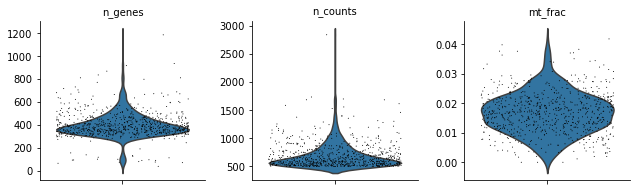

In [17]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

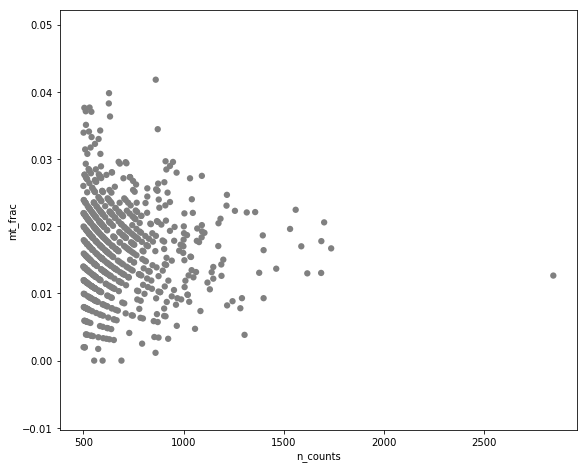

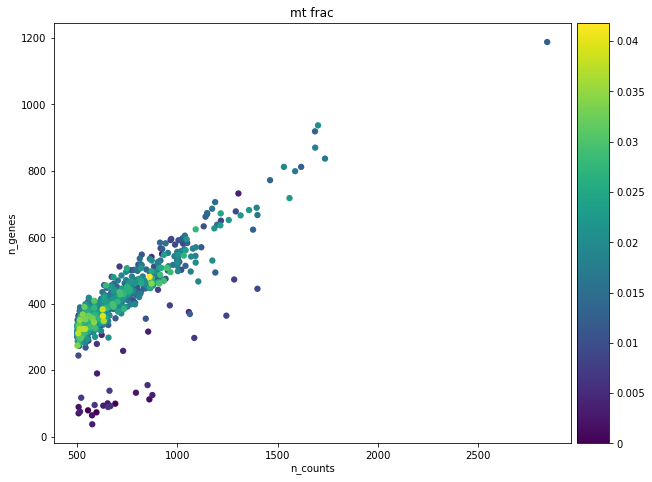

In [18]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

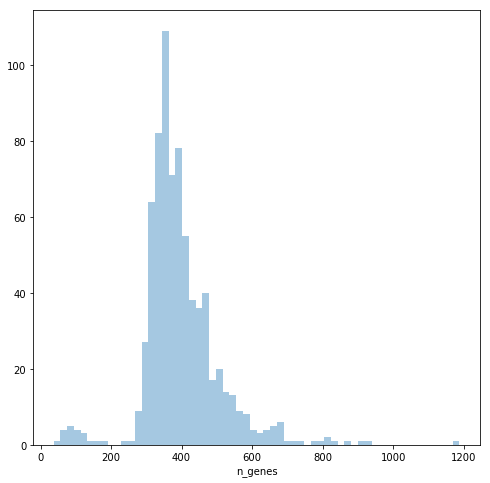

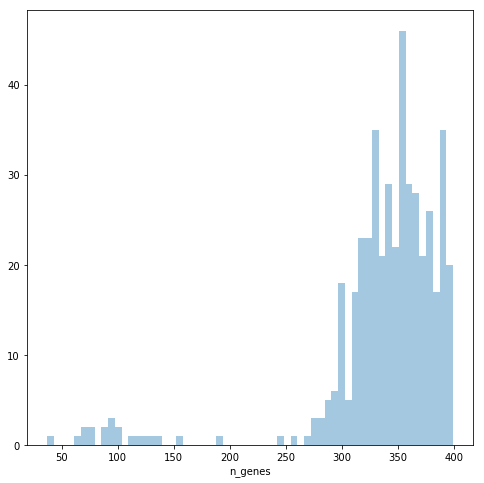

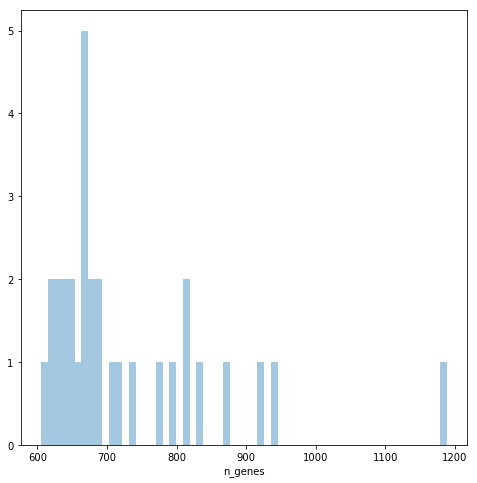

In [19]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<400], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>600], kde=False, bins=60)
plt.show()

From the histogram of number of genes, we can exclude the small population with n_genes < 250 and n_genes > 1000.
No need to threshold on mt_frac.

In [20]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 250)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 746
filtered out 21 cells that haveless than 250 genes expressed
Number of cells after gene filter: 725
filtered out 1 cells that havemore than 1000 genes expressed
Number of cells after gene filter: 724


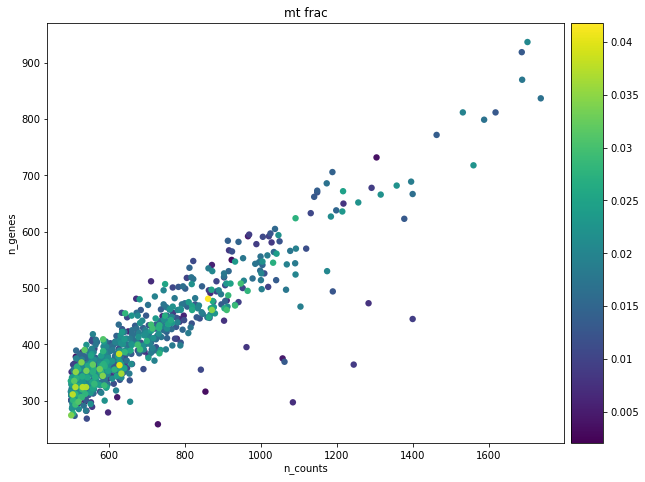

In [21]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

In [22]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 14715
filtered out 7984 genes that are detectedin less than 5 cells
Number of genes after cell filter: 6731


## 1.2 Normalization

In [23]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [24]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    400
1    146
2     84
3     59
4     35
Name: groups, dtype: int64

In [25]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [26]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [27]:
#Delete adata_pp
del adata_pp

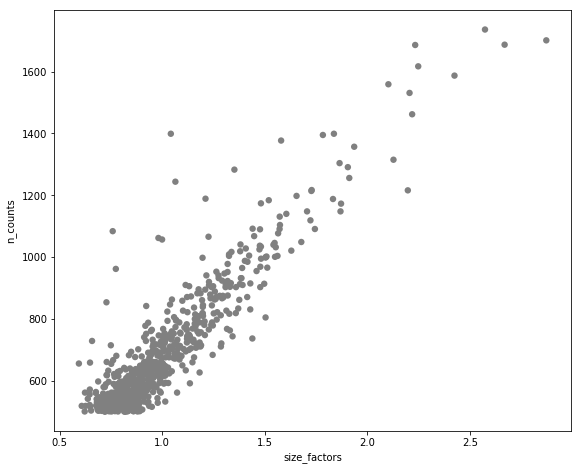

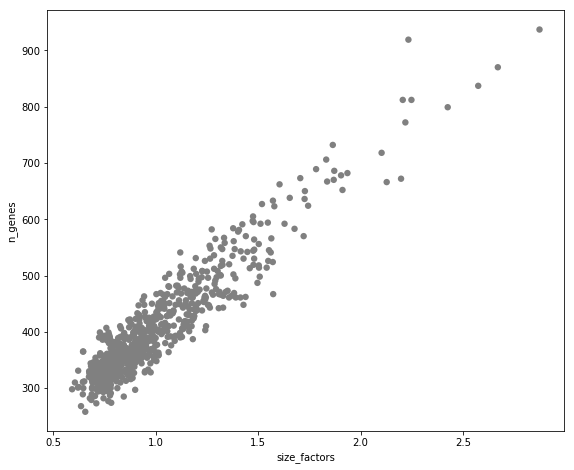

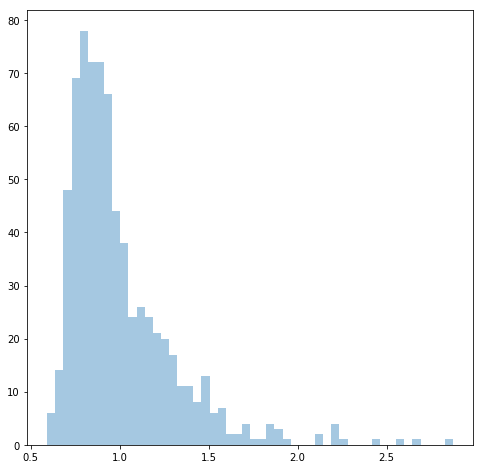

In [28]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [29]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [30]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [31]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [32]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


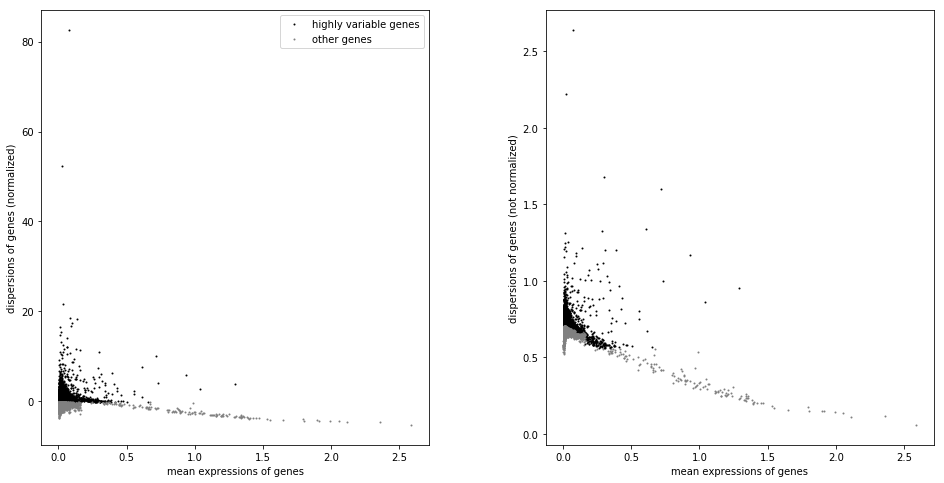

In [33]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [34]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9768379  0.9758531  0.96631074 0.94768417 0.91307914
     0.8087325  0.78612727 0.77869815 0.7651577  0.7491985  0.73642176
     0.7236532  0.7145897  0.6919795 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:04)


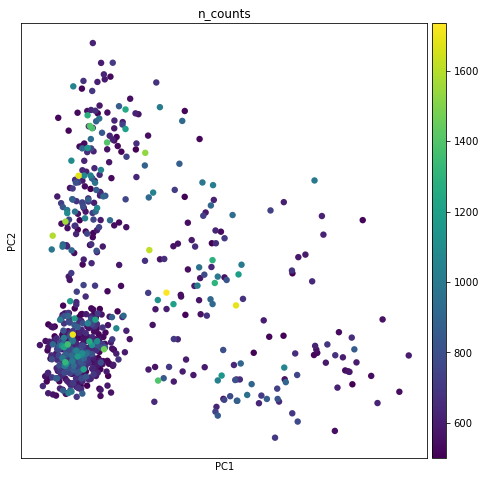

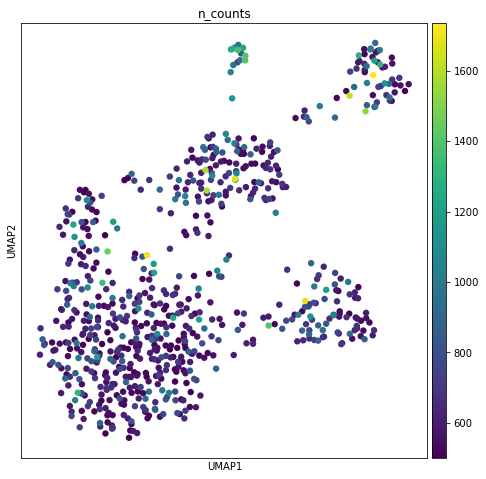

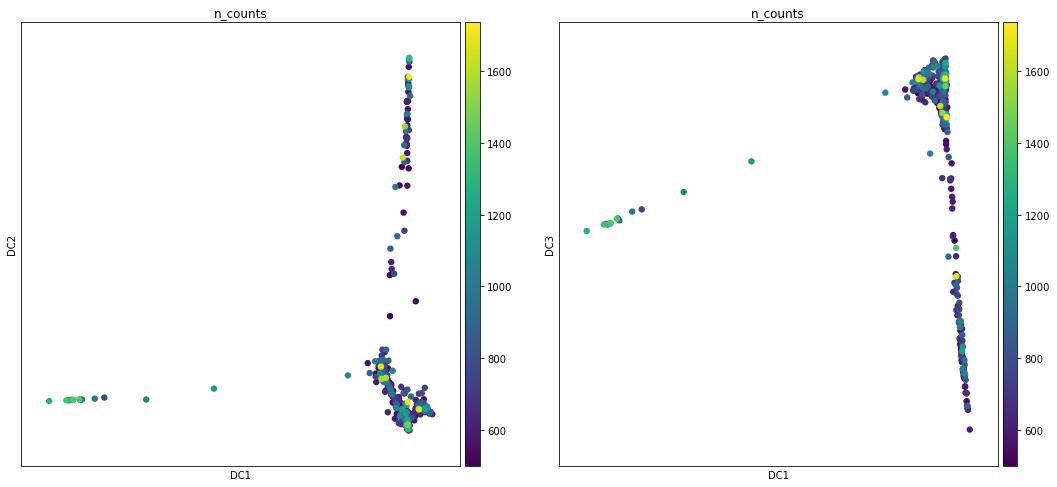

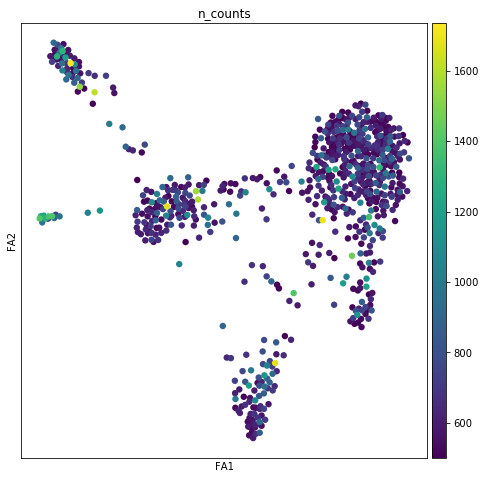

In [35]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [36]:
adata.write(results_file)

# 3. Clustering

In [37]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [38]:
adata.obs['louvain_r1'].value_counts()

0    289
1    139
2     91
3     88
4     54
5     49
6     14
Name: louvain_r1, dtype: int64

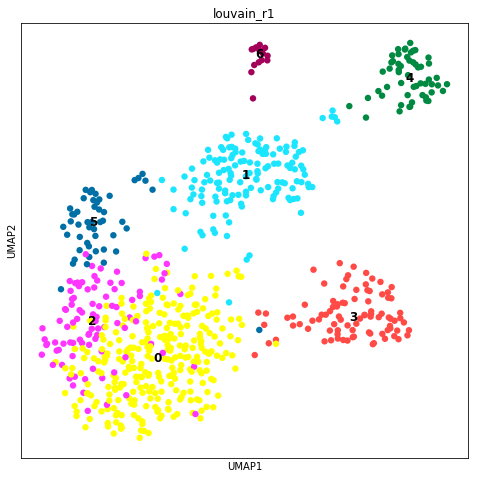

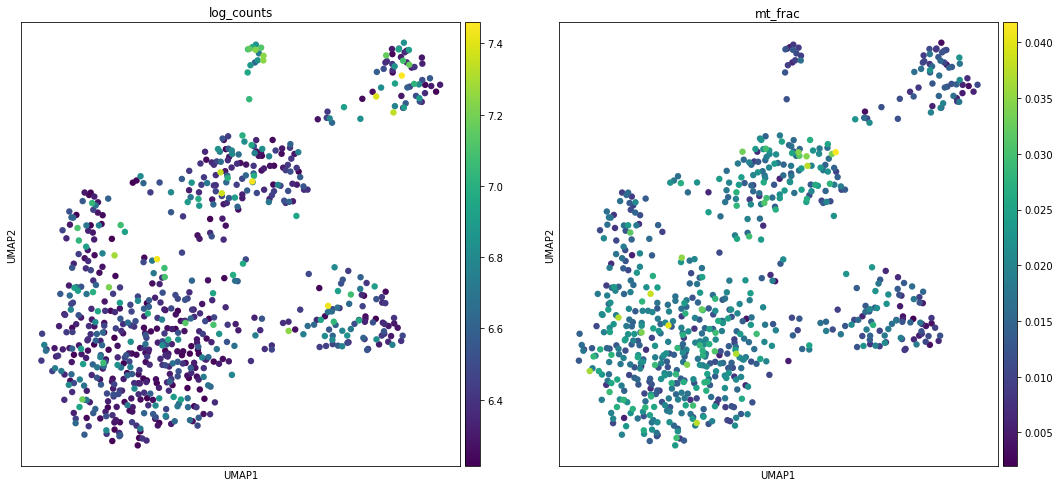

In [39]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. MCA cell type classification
Here we want to annotate the cells with the published classification from the Mouse Cell Atlas. We downloaded the cell annotations from this link. This would serve us as a reference map to identify cell types that share the same markers genes as the one identified for human samples.

In [40]:
mca_class = pd.read_csv('../../Munich/datasets/mouse/MCA_CellAssignments.csv')
mca_class.head()

,Unnamed: 0,Cell.name,ClusterID,Tissue,Batch,Cell.Barcode,Annotation
0,1,Bladder_1.AAAACGAAAACGGGGCGA,Bladder_1,Bladder,Bladder_1,AAAACGAAAACGGGGCGA,Stromal cell_Dpt high(Bladder)
1,2,Bladder_1.AAAACGAAGCGGCCGCTA,Bladder_5,Bladder,Bladder_1,AAAACGAAGCGGCCGCTA,Stromal cell_Car3 high(Bladder)
2,3,Bladder_1.AAAACGAAGTACTAGCAT,Bladder_16,Bladder,Bladder_1,AAAACGAAGTACTAGCAT,Vascular smooth muscle progenitor cell(Bladder)
3,4,Bladder_1.AAAACGACGTTGCTGTGT,Bladder_8,Bladder,Bladder_1,AAAACGACGTTGCTGTGT,Vascular endothelial cell(Bladder)
4,5,Bladder_1.AAAACGAGCGAGCGAGTA,Bladder_4,Bladder,Bladder_1,AAAACGAGCGAGCGAGTA,Urothelium(Bladder)


In [41]:
# Select only tissue of interest
PB_class = mca_class[mca_class['Tissue'] == 'Peripheral_Blood']
PB_class.shape

(7095, 7)

In [42]:
# Prepare the data to be merged to adata.obs, to match the annotation with the correct barcode
pb_df = PB_class[['Cell.name', 'Annotation']].rename(columns = {'Cell.name':'barcode', 'Annotation':'MCA_annotation'})
pb_df['MCA_annotation'] = [i.split('(')[0] for i in pb_df['MCA_annotation']]
pb_df.head()

,barcode,MCA_annotation
161686,PeripheralBlood_1.AAAACGTGTCACGCCCTC,T cell_Gm14303 high
161687,PeripheralBlood_1.AAAGTTAAAACGTCGGGT,T cell_Gm14303 high
161688,PeripheralBlood_1.AAAGTTACGTTGCTGAAA,T cell_Gm14303 high
161689,PeripheralBlood_1.AAAGTTGTCCCGGGACAT,T cell_Gm14303 high
161690,PeripheralBlood_1.AACCTAAAGCGGATCAAC,B cell_Rps27rt high


In [43]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1
0,PeripheralBlood_6.GAATTAAACGCCGCAGGA,1399.0,7.243513,445,0.009292,1.041412,6
1,PeripheralBlood_6.CACAAGCTGAAAACAATA,1244.0,7.126087,364,0.008842,1.063664,6
2,PeripheralBlood_6.CTCGCATATTGTTCGTAA,1687.0,7.430707,870,0.017783,2.669829,1
3,PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,1587.0,7.369601,799,0.017013,2.425266,1
4,PeripheralBlood_6.AAGCGGACACCCCTCCAT,1736.0,7.459339,837,0.016705,2.574109,4


In [44]:
# merge the two dataframes
adata_merge = adata_df.merge(pb_df, how='left', on='barcode')
adata_merge.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,MCA_annotation
0,PeripheralBlood_6.GAATTAAACGCCGCAGGA,1399.0,7.243513,445,0.009292,1.041412,6,B cell_Igha high
1,PeripheralBlood_6.CACAAGCTGAAAACAATA,1244.0,7.126087,364,0.008842,1.063664,6,B cell_Igha high
2,PeripheralBlood_6.CTCGCATATTGTTCGTAA,1687.0,7.430707,870,0.017783,2.669829,1,NaN
3,PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,1587.0,7.369601,799,0.017013,2.425266,1,T cell_Trbc2 high
4,PeripheralBlood_6.AAGCGGACACCCCTCCAT,1736.0,7.459339,837,0.016705,2.574109,4,Macrophage_S100a4 high


In [45]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

... storing 'MCA_annotation' as categorical


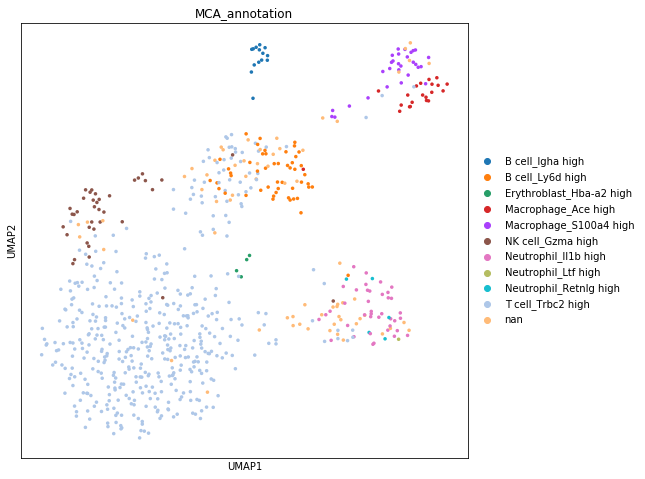

In [46]:
sc.pl.umap(adata, color='MCA_annotation', size= 50)

# 5. Plot makers of cell types

In [47]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells
We want to annotate CD8+ versus CD4+ cells.

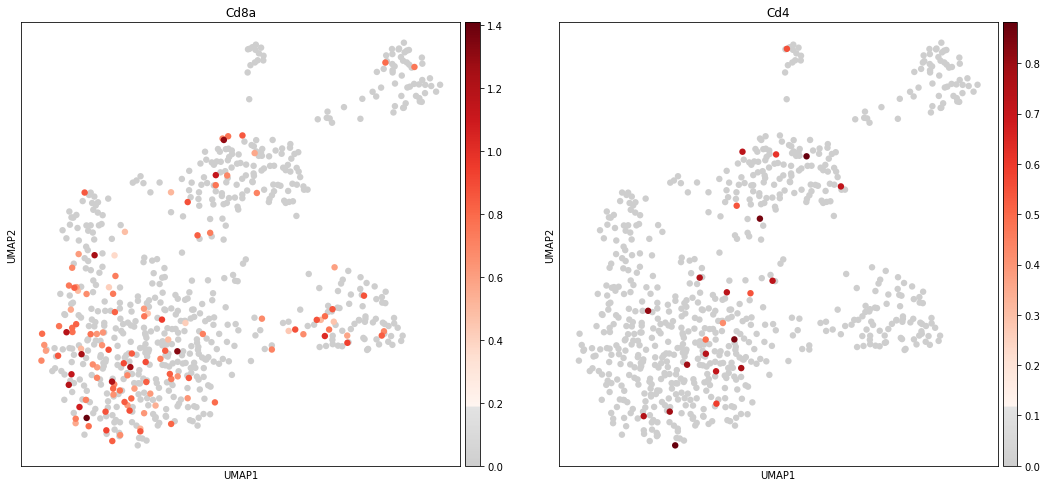

In [48]:
#Canonical markers Cd8b not present
sc.pl.umap(adata, color=['Cd8a', 'Cd4'], use_raw=False, color_map=mymap)

Cluster 0 and 2 are CD8+. Few CD4+ cells.

### Natural killer T cells and NK cells
We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

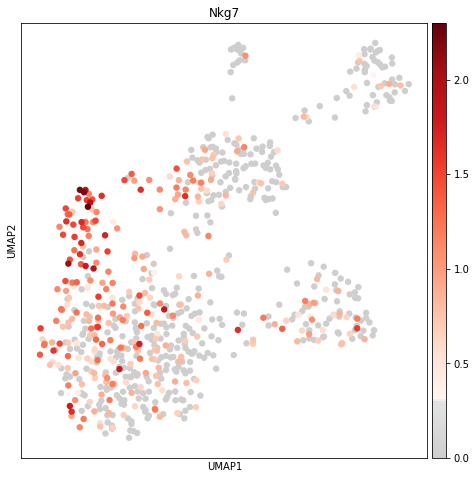

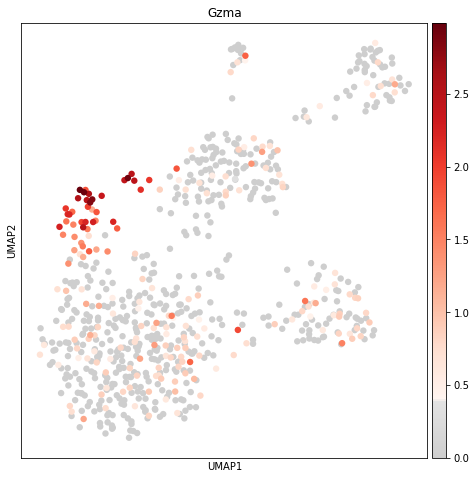

In [49]:
# Gnly and Cd160 not there
sc.pl.umap(adata, color=['Nkg7'], use_raw=False, color_map=mymap)
sc.pl.umap(adata, color=['Gzma'], use_raw=False, color_map=mymap)

Cluster 2 is NKT cells. Cluster 5 is NK cells.

## Monocytes: CD14+ and CD16+

Monocytes markers are not present in the data.

In [51]:
# Cd16 not there
#sc.pl.umap(adata, color=['Cd14'], use_raw=False, color_map=mymap)

## Monocyte progenitors

Markers from MCA Bone Marrow

In [54]:
# Markers from MCA
#sc.pl.umap(adata, color=['Prtn3','Ctsg'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells
Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

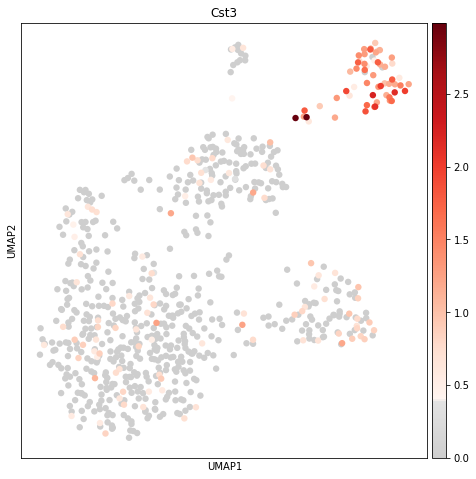

In [56]:
# Fcer1a not there
sc.pl.umap(adata, color=['Cst3'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

In [58]:
#Gzmb not there
#sc.pl.umap(adata, color=['Il3ra'], use_raw=False, color_map=mymap)

## B cells
Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).

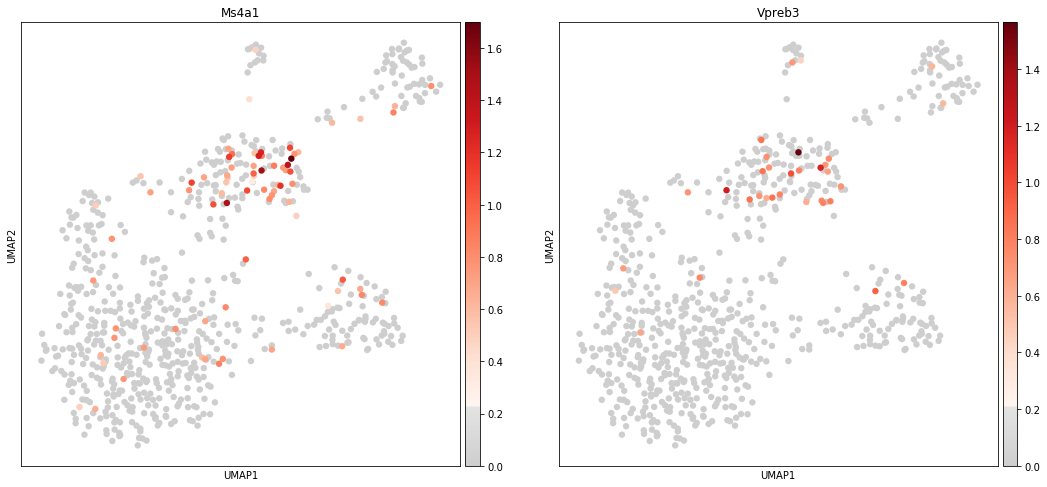

In [61]:
# Mme not there
sc.pl.umap(adata, color=['Ms4a1', 'Vpreb3'], use_raw=False, color_map=mymap)

## Erythrocytes

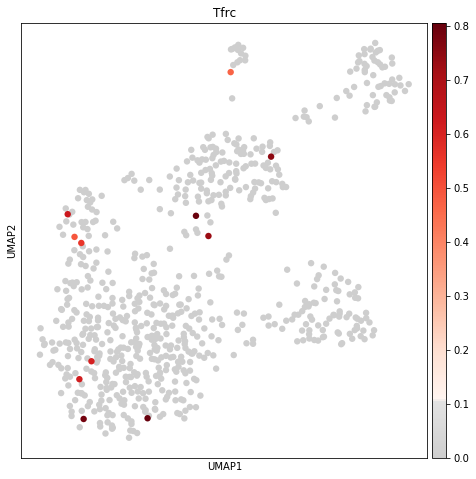

In [63]:
# markers from CellMarker (differentiated)  Gypa not there
sc.pl.umap(adata, color=['Tfrc'], use_raw=False, color_map=mymap)

## Neutrophils

Markers from Mouse Bone Marrow (Dahlin et al)

In [67]:
#sc.pl.umap(adata, color=['Elane', 'Gfi1', 'Cebpe'], use_raw=False, color_map=mymap)

## Basophils

Markers from Mouse Bone Marrow (Dahlin et al)

In [69]:
#sc.pl.umap(adata, color=['Ms4a2', 'Cpa3' ], use_raw=False, color_map=mymap, size=40)

# 7. Final cell-type annotation

In [70]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1']
adata.rename_categories('final_annotation', ['T cells', 
                                             'CD20+ B cells', 
                                             'NKT cells', 
                                             'Neutrophils', 
                                             'Monocytes',
                                             'NK cells', 
                                             'Unknown'])

In [72]:
adata = adata[adata.obs['final_annotation'] != 'Unknown']

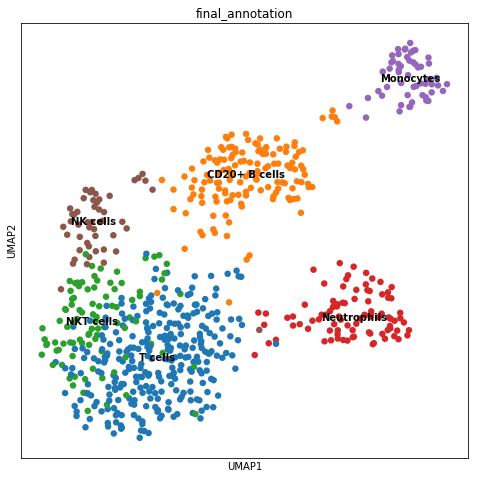

In [73]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [74]:
# save final result
adata.write(results_file)